In [1]:
import json
import numpy as np
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

from tree_registration_and_matching.constants import DATA_DIR
from tree_registration_and_matching.register_CHM import find_best_shift

## Constants
These constants represent file paths to the input data. You can change which dataset is used by editing the `DATASET` variable.

In [2]:
# This can be changed to select another dataset
DATASET = "0061_000333_000335"

FIELD_TREES = Path(DATA_DIR, "ofo-tree-registration", "field_trees.gpkg")
PLOTS_FILE = Path(DATA_DIR, "ofo-tree-registration", "plot_bounds.gpkg")
SHIFTS_FILE = Path(DATA_DIR, "ofo-tree-registration", "shifts_per_dataset.json")
CHM = Path(DATA_DIR, "ofo-tree-registration", "CHMs", f"{DATASET}.tif")

# This controls the start, stop, and step of the grid of candidate shifts that are tested
CANDIDATE_SHIFT_RANGE = (-12, 12, 0.5)
# This is a scalar multiple of the height to control the point size while plotting
HEIGHT_PLOTTING_SCALE = 0.25

## Read the data
Load the canopy height model (CHM) raster, field tree points, boundary of the field plot, and the shift that was manually computed to register the field data to the CHM.

In [3]:
# Read the data
CHM_handler = rio.open(CHM)
all_field_trees = gpd.read_file(FIELD_TREES)
all_plots = gpd.read_file(PLOTS_FILE)

# And convert the CRS of the vector data so it matches that of the CHM
all_field_trees.to_crs(CHM_handler.crs, inplace=True)
all_plots.to_crs(CHM_handler.crs, inplace=True)

# Read the shifts
with open(SHIFTS_FILE) as infile:
    data = json.load(infile)
shift = data[DATASET][0]

# Extract the one plot from the total
plot_bounds = all_plots.query("dataset_id==@DATASET")
field_trees = all_field_trees.query("dataset_id==@DATASET")

## Shift the field data
The field trees and corresponding plot bounds already have the optimal translation applied to match the corresponding drone product. To conduct the experiment, we must re-introduce the error. This is done by shifting by the negative of the recorded shift.

In [4]:
plot_bounds.geometry = plot_bounds.translate(xoff=-shift[0], yoff=-shift[1])
field_trees.geometry = field_trees.translate(xoff=-shift[0], yoff=-shift[1])

/home/exouser/miniconda3/envs/TRAM-dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Visualize input data
Plot the canopy height model (CHM) with the field trees (red, sized by measured height) and the plot bounds (cyan). Note, the trees and bounds are shifted relative to the CHM due to measurement errors in field.

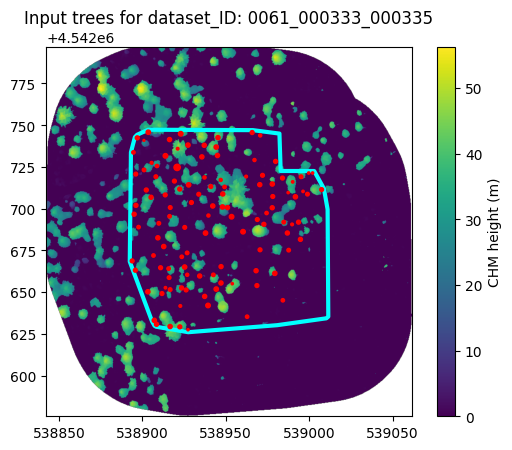

In [5]:
f, ax = plt.subplots()
# Show the CHM
ret = show(CHM_handler, ax=ax, adjust=False)
im = ret.get_images()[0]
f.colorbar(im, ax=ax, label="CHM height (m)")

# Show the plot bounds and field trees
plot_bounds.plot(
    ax=ax, facecolor="none", edgecolor="cyan", linewidth=3, label="Plot bounds"
)
# The height of the trees can be rescaled for different size dots
field_trees.plot(
    ax=ax, markersize=field_trees["height"] * HEIGHT_PLOTTING_SCALE, c="red"
)

ax.set_title(f"Input trees for dataset_ID: {DATASET}")

plt.show()
plt.close()

## Registration
Run registration between the field trees and the CHM. In this algorith, a grid of shifts are applied to the entire set of trees and the correlation between the field-measured tree heights and corresponding location on the CHM are computed. The shift corresponding to the heighest correlation value is selected as the optimal. In an attempt to diagnose the quality, we compute the correlation of the next-best shift, where this is defined as a shift not within the watershed basin of convergence of the optimal shift. A low ratio of second best to optimal may indicate an high quality registration, as it suggests an un-ambigious solution. But this has not been validated in our experiments.

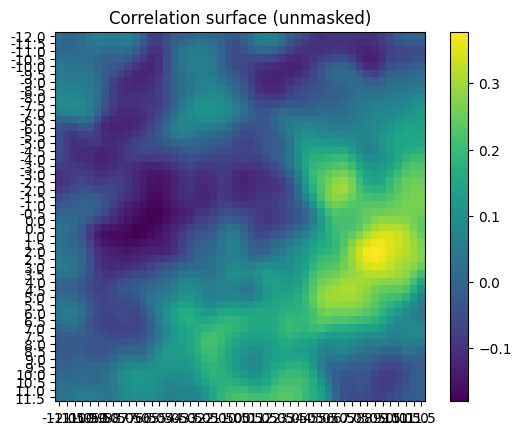

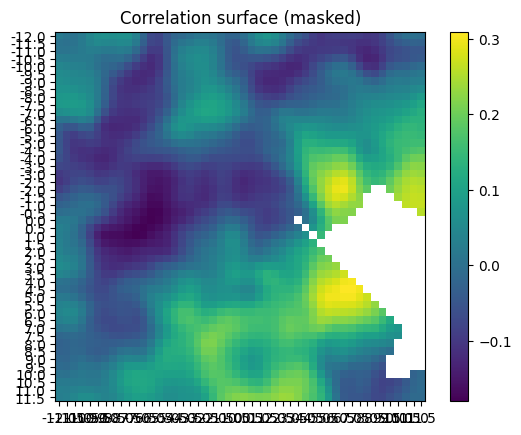

Optimal shift applied: (np.float64(8.5), np.float64(2.0))
Error (m) from manually-computed optimum: [ 0.10187817 -0.50978001]
Quality ratio metric: 0.8180440787117205


In [6]:
estimated_shift, metrics = find_best_shift(
    tree_points=field_trees,
    CHM=CHM_handler,
    plot_bounds=plot_bounds,
    vis=True,
    x_range=CANDIDATE_SHIFT_RANGE,
    y_range=CANDIDATE_SHIFT_RANGE,
)
print(f"Optimal shift applied: {estimated_shift}")
print(
    f"Error (m) from manually-computed optimum: {np.array(shift) - np.array(estimated_shift)}"
)

print(f"Quality ratio metric: {metrics["ratio"]}")

## Plot the shifted trees
Apply the optimal shift and visualize again

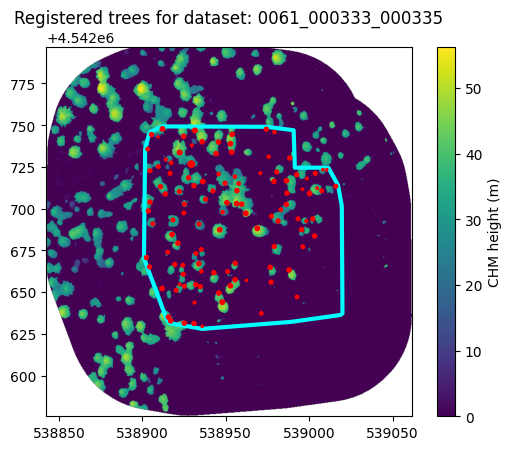

In [7]:
# Create a shifted copy of the trees and plot bounds
registered_field_trees = field_trees.copy()
registered_plot_bounds = plot_bounds.copy()

registered_field_trees.geometry = registered_field_trees.translate(
    xoff=estimated_shift[0], yoff=estimated_shift[1]
)
registered_plot_bounds.geometry = registered_plot_bounds.translate(
    xoff=estimated_shift[0], yoff=estimated_shift[1]
)

# Plot the CHM
f, ax = plt.subplots(1, 1)
ret = show(CHM_handler, ax=ax, adjust=False)
im = ret.get_images()[0]
f.colorbar(im, ax=ax, label="CHM height (m)")

# Plot the trees and bounds
registered_plot_bounds.plot(ax=ax, facecolor="none", edgecolor="cyan", linewidth=3)
registered_field_trees.plot(
    ax=ax, markersize=field_trees["height"] * HEIGHT_PLOTTING_SCALE, c="red"
)
ax.set_title(f"Registered trees for dataset: {DATASET}")
plt.show()
plt.close()